# Deep Learning Basics

This tutorial introduces to basics of Neural Networks and Deep Learning

* Theory:
    * History of Neural Networks
    * Theory Perceptrons
    * Activation Functions (sigmoid, softmax, relu)
    * Loss
    * Training
    * Mini-Batch
* Example: simple: create NN, Train NN, Observe Loss, -> Notebook only
* Theory:
    * Optimization (SGD, ADAM)
    * Binary vs. multi-class categorization
    * Overfitting
    * Dropout
    * (just mention BatchNormalization, Regularization)
* Example:  (Music vs. speech classification (GTZAN Music-speech))
    * Tensorboard
    * Overfitting
    * Optimizers: show Adam learns much faster


## General Requirements

In [66]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy  as np
import pandas as pd

import librosa
from librosa import display

import IPython

## Requirements for Deep Learning

### GPU-based Computing

### Tensorflow

Tell Tensorflow which GPU to use (if you have more than one)

In [67]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Import Tensorflow

In [68]:
import tensorflow as tf

### Mid-Level API - Keras

In [69]:
import keras

## Data

**Music Speech Data Set**

by *George Tzanetakis*. Collected for the purposes of music/speech discrimination. Consists of 128 tracks, each 30 seconds long. Each class (music/speech) has 64 examples in 22050Hz Mono 16-bit WAV audio format. 

In [70]:
DATASET_PATH = "/home/schindler/tutorials/mlprague2018/data/gtzan_music_speech"

**Load Metadata**

In [71]:
metadata         = pd.read_csv("%s/filelist_wav_relpath_wclasses.txt" % DATASET_PATH, sep="\t", header=None)
metadata.columns = ["filename", "label"]

In [72]:
with np.load("%s/mel_spectrogram_segments.npz" % DATASET_PATH) as npz:
    x         = npz["data"]
    filenames = npz["filenames"]

**Train data**

In [73]:
num_train_examples, num_mels, num_frames = x.shape

print("num_train_examples: %d"    % num_train_examples)
print("spectrogram shape : %dx%d" % (num_mels, num_frames))

num_train_examples: 128
spectrogram shape : 40x80


/home/schindler/anaconda/python2/envs/py36/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


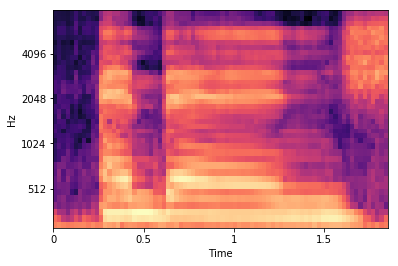

In [74]:
librosa.display.specshow(x[0], y_axis='mel', fmax=8000, x_axis='time');

**Train target values / Ground Truth**

In [75]:
y = metadata.label

In [76]:
y.shape

(128,)

In [77]:
y[:10]

0    speech
1    speech
2    speech
3    speech
4    speech
5    speech
6    speech
7    speech
8    speech
9    speech
Name: label, dtype: object

### Prepare data for the Neural Network

#### Preprocess data

Flatten images and convert them into a 1D vector

In [78]:
input_resolution = num_mels * num_frames
input_resolution

3200

In [79]:
x = x.reshape(num_train_examples, 1, input_resolution)

In [80]:
print("x.shape:", x.shape)

x.shape: (128, 1, 3200)


Cast to floating point representation (float32 required input for Tensorflow with most consumer GPUs)

In [81]:
x = x.astype('float32')

Scale input data (neural network input should be scaled around 0. Data normalization techniques will be explained in part 2).

In [82]:
print("min : %f" % np.min(x))
print("max : %f" % np.max(x))
print("mean: %f" % np.mean(x))
print("std : %f" % np.std(x))

min : -80.000000
max : 0.000000
mean: -39.275799
std : 14.900629


In [83]:
x = x - x.mean()
x = x / x.std()

In [84]:
print("min : %f" % np.min(x))
print("max : %f" % np.max(x))
print("mean: %f" % np.mean(x))
print("std : %f" % np.std(x))

min : -2.733052
max : 2.635848
mean: 0.000000
std : 1.000000


#### Preprocess Ground Truth

Convert numerical class labels to binary class matrices

In [85]:
y[:10]

0    speech
1    speech
2    speech
3    speech
4    speech
5    speech
6    speech
7    speech
8    speech
9    speech
Name: label, dtype: object

**Numerically encode String Labels**

In [86]:
from sklearn.preprocessing import LabelEncoder

In [87]:
encoder = LabelEncoder()
encoder.fit(y)

LabelEncoder()

In [88]:
y_encoded = encoder.transform(y)

In [89]:
y_encoded = np.expand_dims(y_encoded,1)
y_encoded = np.expand_dims(y_encoded,1)

In [90]:
y_encoded.shape

(128, 1, 1)

## Build the Deep Learning model

### Define Network layers

Define the Input

* define shape

In [91]:
from keras.layers import Input

In [92]:
model_input = Input(shape=(1,input_resolution))

The input is passed to the first hidden layer - first fully connected layer

* define layer
* define number of units
* define activation function

In [93]:
from keras.layers.core import Dense

In [94]:
fc1 = Dense(512, activation="sigmoid")(model_input)

Add another hidden layer

In [95]:
fc2 = Dense(512, activation="sigmoid")(fc1)

Add output layer

In [96]:
out = Dense(1, activation="sigmoid")(fc2)

**Define Model**

In [97]:
from keras.models import Model

In [98]:
model = Model(inputs=[model_input], outputs=[out])

Show model architecture

In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1, 3200)           0         
_________________________________________________________________
dense_25 (Dense)             (None, 1, 512)            1638912   
_________________________________________________________________
dense_26 (Dense)             (None, 1, 512)            262656    
_________________________________________________________________
dense_27 (Dense)             (None, 1, 1)              513       
Total params: 1,902,081
Trainable params: 1,902,081
Non-trainable params: 0
_________________________________________________________________


### Compile Model

* define the loss function
* define the optimizaton strategy
* define performance metrics

In [100]:
from keras.optimizers import SGD

In [101]:
model.compile(loss      = 'binary_crossentropy',
              optimizer = SGD(lr=0.05),
              metrics   =['accuracy'])

## Train the Model

In [102]:
hist = model.fit(x,
                 y_encoded,
                 batch_size = 24,
                 epochs     = 50,
                 verbose    = 1)

Epoch 1/50
128/128 [==============================] - 1s 7ms/step - loss: 0.9195 - acc: 0.4844
Epoch 2/50
128/128 [==============================] - 0s 236us/step - loss: 0.7084 - acc: 0.5547
Epoch 3/50
128/128 [==============================] - 0s 221us/step - loss: 0.7946 - acc: 0.4609
Epoch 4/50
128/128 [==============================] - 0s 204us/step - loss: 0.6389 - acc: 0.6641
Epoch 5/50
128/128 [==============================] - 0s 210us/step - loss: 0.6103 - acc: 0.6797
Epoch 6/50
128/128 [==============================] - 0s 201us/step - loss: 0.7722 - acc: 0.5937
Epoch 7/50
128/128 [==============================] - 0s 209us/step - loss: 0.5331 - acc: 0.7422
Epoch 8/50
128/128 [==============================] - 0s 220us/step - loss: 0.5785 - acc: 0.6641
Epoch 9/50
128/128 [==============================] - 0s 216us/step - loss: 0.5717 - acc: 0.7266
Epoch 10/50
128/128 [==============================] - 0s 202us/step - loss: 0.5681 - acc: 0.6797
Epoch 11/50
128/128 [==========

**Visualize training progress**

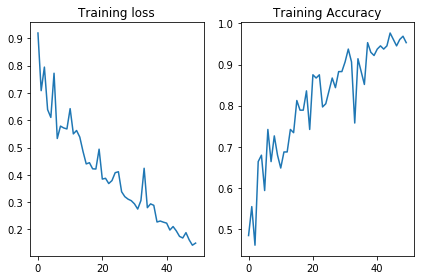

In [103]:
plt.subplot(1, 2, 1)
plt.title("Training loss")
plt.plot(range(50),hist.history["loss"])

plt.subplot(1, 2, 2)
plt.title("Training Accuracy")
plt.plot(range(50),hist.history["acc"])

plt.tight_layout()

**Predict Audio Files**

In [104]:
IPython.display.Audio("%s/%s" % (DATASET_PATH, metadata.iloc[0].filename))

In [105]:
predictions = model.predict(x[0:1])
predictions[0,0,0]

0.9720472

In [106]:
IPython.display.Audio("%s/%s" % (DATASET_PATH, metadata.iloc[100].filename))

In [107]:
predictions = model.predict(x[100:101])
predictions[0,0,0]

0.05897461

# Model Evalution

## Validation Split

In [108]:
from sklearn.model_selection import StratifiedShuffleSplit

In [109]:
sss = StratifiedShuffleSplit(n_splits=1)

splits              = sss.split(x, y)
train_idx, test_idx = list(splits)[0]

In [110]:
model_input = Input(shape=(1,input_resolution))

fc1   = Dense(512, activation="sigmoid")(model_input)
fc2   = Dense(512, activation="sigmoid")(fc1)
out   = Dense(1,   activation="sigmoid")(fc2)
model = Model(inputs=[model_input], outputs=[out])

model.compile(loss      = 'binary_crossentropy',
              optimizer = SGD(lr=0.05),
              metrics   = ['accuracy'])

In [111]:
hist = model.fit(x[train_idx],
                 y_encoded[train_idx],
                 batch_size = 24,
                 epochs     = 50,
                 verbose    = 1,
                 validation_data=(x[test_idx], y_encoded[test_idx]))

Train on 115 samples, validate on 13 samples
Epoch 1/50
115/115 [==============================] - 1s 6ms/step - loss: 0.6899 - acc: 0.4870 - val_loss: 1.0006 - val_acc: 0.5385
Epoch 2/50
115/115 [==============================] - 0s 255us/step - loss: 1.1544 - acc: 0.3913 - val_loss: 0.7241 - val_acc: 0.5385
Epoch 3/50
115/115 [==============================] - 0s 246us/step - loss: 0.6377 - acc: 0.6435 - val_loss: 0.6748 - val_acc: 0.6154
Epoch 4/50
115/115 [==============================] - 0s 238us/step - loss: 0.6766 - acc: 0.5739 - val_loss: 0.8745 - val_acc: 0.5385
Epoch 5/50
115/115 [==============================] - 0s 242us/step - loss: 0.6220 - acc: 0.6522 - val_loss: 0.8425 - val_acc: 0.5385
Epoch 6/50
115/115 [==============================] - 0s 242us/step - loss: 0.6760 - acc: 0.6348 - val_loss: 0.7492 - val_acc: 0.6154
Epoch 7/50
115/115 [==============================] - 0s 253us/step - loss: 0.6324 - acc: 0.6522 - val_loss: 0.8751 - val_acc: 0.5385
Epoch 8/50
115/115 

# Visualize Training Progress with Tensorboard

In [112]:
model_input = Input(shape=(1,input_resolution))

fc1   = Dense(512, activation="sigmoid")(model_input)
fc2   = Dense(512, activation="sigmoid")(fc1)
out   = Dense(1,   activation="sigmoid")(fc2)
model = Model(inputs=[model_input], outputs=[out])

model.compile(loss      = 'binary_crossentropy',
              optimizer = SGD(lr=0.05),
              metrics   = ['accuracy'])

In [113]:
from keras.callbacks import TensorBoard

In [114]:
tb_callback = TensorBoard(log_dir="./tensorboard/model_1")

In [115]:
hist = model.fit(x[train_idx],
                 y_encoded[train_idx],
                 batch_size = 24,
                 epochs     = 500,
                 verbose    = 0,
                 callbacks=[tb_callback],
                 validation_data=(x[test_idx], y_encoded[test_idx]))

# Counteract Overfitting

## Dropouts

In [116]:
from keras.layers import Dropout

In [117]:
model_input = Input(shape=(1,input_resolution))

fc1   = Dense(512, activation="sigmoid")(model_input)
do1   = Dropout(0.1)(fc1)
fc2   = Dense(512, activation="sigmoid")(do1)
do2   = Dropout(0.1)(fc2)
out   = Dense(1, activation="sigmoid")(do2)
model = Model(inputs=[model_input], outputs=[out])

model.compile(loss      = 'binary_crossentropy',
              optimizer = SGD(lr=0.05),
              metrics   = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1, 3200)           0         
_________________________________________________________________
dense_34 (Dense)             (None, 1, 512)            1638912   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
dense_35 (Dense)             (None, 1, 512)            262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 1, 1)              513       
Total params: 1,902,081
Trainable params: 1,902,081
Non-trainable params: 0
_________________________________________________________________


In [118]:
tb_callback = TensorBoard(log_dir="./tensorboard/model_2")

hist = model.fit(x[train_idx],
                 y_encoded[train_idx],
                 batch_size = 24,
                 epochs     = 500,
                 verbose    = 0,
                 callbacks=[tb_callback],
                 validation_data=(x[test_idx], y_encoded[test_idx]))

## Regularization

In [119]:
from keras.regularizers import l1

In [120]:
model_input = Input(shape=(1,input_resolution))

fc1   = Dense(512, activation="sigmoid", kernel_regularizer=l1(0.0001))(model_input)
do1   = Dropout(0.1)(fc1)
fc2   = Dense(512, activation="sigmoid", kernel_regularizer=l1(0.0001))(do1)
do2   = Dropout(0.1)(fc2)
out   = Dense(1, activation="sigmoid")(do2)
model = Model(inputs=[model_input], outputs=[out])

model.compile(loss      = 'binary_crossentropy',
              optimizer = SGD(lr=0.05),
              metrics   = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 1, 3200)           0         
_________________________________________________________________
dense_37 (Dense)             (None, 1, 512)            1638912   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 1, 512)            262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
dense_39 (Dense)             (None, 1, 1)              513       
Total params: 1,902,081
Trainable params: 1,902,081
Non-trainable params: 0
_________________________________________________________________


In [121]:
tb_callback = TensorBoard(log_dir="./tensorboard/model_3")

hist = model.fit(x[train_idx],
                 y_encoded[train_idx],
                 batch_size = 24,
                 epochs     = 500,
                 verbose    = 0,
                 callbacks=[tb_callback],
                 validation_data=(x[test_idx], y_encoded[test_idx]))

## Learning Rate Decay

In [122]:
from keras.callbacks import LearningRateScheduler

import math

In [123]:
# learning rate schedule
def step_decay(epoch):
    
    initial_lrate = 0.05
    drop          = 0.5
    epochs_drop   = 50.0
    
    learn_rate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return learn_rate

In [124]:
model_input = Input(shape=(1,input_resolution))

fc1   = Dense(512, activation="sigmoid")(model_input)
do1   = Dropout(0.1)(fc1)
fc2   = Dense(512, activation="sigmoid")(do1)
do2   = Dropout(0.1)(fc2)
out   = Dense(1, activation="sigmoid")(do2)
model = Model(inputs=[model_input], outputs=[out])

model.compile(loss      = 'binary_crossentropy',
              optimizer = SGD(lr=0.05),
              metrics   = ['accuracy'])

In [125]:
tb_callback = TensorBoard(log_dir="./tensorboard/model_4")
lr_schedule = LearningRateScheduler(step_decay, verbose=1)

hist = model.fit(x[train_idx],
                 y_encoded[train_idx],
                 batch_size = 24,
                 epochs     = 500,
                 verbose    = 0,
                 callbacks=[tb_callback, lr_schedule],
                 validation_data=(x[test_idx], y_encoded[test_idx]))


Epoch 00001: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.05.

Epoch 00015: LearningRateScheduler reducing lea


Epoch 00122: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00123: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00124: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00125: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00126: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00127: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00128: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00129: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00130: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00131: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00132: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00133: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00134: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00135: LearningRateScheduler reducing learning rate to 0.0125.

Epoch 00136: Learni


Epoch 00241: LearningRateScheduler reducing learning rate to 0.003125.

Epoch 00242: LearningRateScheduler reducing learning rate to 0.003125.

Epoch 00243: LearningRateScheduler reducing learning rate to 0.003125.

Epoch 00244: LearningRateScheduler reducing learning rate to 0.003125.

Epoch 00245: LearningRateScheduler reducing learning rate to 0.003125.

Epoch 00246: LearningRateScheduler reducing learning rate to 0.003125.

Epoch 00247: LearningRateScheduler reducing learning rate to 0.003125.

Epoch 00248: LearningRateScheduler reducing learning rate to 0.003125.

Epoch 00249: LearningRateScheduler reducing learning rate to 0.003125.

Epoch 00250: LearningRateScheduler reducing learning rate to 0.0015625.

Epoch 00251: LearningRateScheduler reducing learning rate to 0.0015625.

Epoch 00252: LearningRateScheduler reducing learning rate to 0.0015625.

Epoch 00253: LearningRateScheduler reducing learning rate to 0.0015625.

Epoch 00254: LearningRateScheduler reducing learning rate t


Epoch 00359: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00360: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00361: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00362: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00363: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00364: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00365: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00366: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00367: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00368: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00369: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00370: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00371: LearningRateScheduler reducing learning rate to 0.000390625.

Epoch 00372: LearningRat


Epoch 00472: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00473: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00474: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00475: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00476: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00477: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00478: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00479: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00480: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00481: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00482: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00483: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00484: LearningRateScheduler reducing learning rate to 9.765625e-05.

Epoch 00485

## Early Stopping

In [126]:
from keras.callbacks import EarlyStopping

In [127]:
model_input = Input(shape=(1,input_resolution))

fc1   = Dense(512, activation="sigmoid")(model_input)
do1   = Dropout(0.1)(fc1)
fc2   = Dense(512, activation="sigmoid")(do1)
do2   = Dropout(0.1)(fc2)
out   = Dense(1, activation="sigmoid")(do2)
model = Model(inputs=[model_input], outputs=[out])

model.compile(loss      = 'binary_crossentropy',
              optimizer = SGD(lr=0.05),
              metrics   = ['accuracy'])

In [128]:
tb_callback = TensorBoard(log_dir="./tensorboard/model_5")
lr_schedule = LearningRateScheduler(step_decay)

early_stop  = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)

hist = model.fit(x[train_idx],
                 y_encoded[train_idx],
                 batch_size = 24,
                 epochs     = 500,
                 verbose    = 0,
                 callbacks=[tb_callback, lr_schedule, early_stop],
                 validation_data=(x[test_idx], y_encoded[test_idx]))

Epoch 00025: early stopping


# Learning Faster

In [129]:
from keras.optimizers import Adam

In [130]:
model_input = Input(shape=(1,input_resolution))

fc1   = Dense(512, activation="sigmoid")(model_input)
do1   = Dropout(0.1)(fc1)
fc2   = Dense(512, activation="sigmoid")(do1)
do2   = Dropout(0.1)(fc2)
out   = Dense(1, activation="sigmoid")(do2)
model = Model(inputs=[model_input], outputs=[out])

model.compile(loss      = 'binary_crossentropy',
              optimizer = Adam(lr=0.0005),
              metrics   = ['accuracy'])


tb_callback = TensorBoard(log_dir="./tensorboard/model_6")

hist = model.fit(x[train_idx],
                 y_encoded[train_idx],
                 batch_size = 24,
                 epochs     = 500,
                 verbose    = 0,
                 callbacks=[tb_callback],
                 validation_data=(x[test_idx], y_encoded[test_idx]))